# Lab 3: Gesture Recognition using Convolutional Neural Networks

In this lab you will train a convolutional neural network to make classifications on different hand gestures. By the end of the lab, you should be able to:

1. Load and split data for training, validation and testing
2. Train a Convolutional Neural Network
3. Apply transfer learning to improve your model

Note that for this lab we will not be providing you with any starter code. You should be able to take the code used in previous labs, tutorials and lectures and modify it accordingly to complete the tasks outlined below.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information. Make sure to review the PDF submission to ensure that your answers are easy to read. Make sure that your text is not cut off at the margins.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1a-1m-5sBTYCRH7Yyj8VRd5w07oiKdaDP?usp=sharing

In [ ]:
%%shell
jupyter nbconvert --to html /content/Lab3_Gesture_Recognition_new.ipynb

[NbConvertApp] Converting notebook /content/Lab3_Gesture_Recognition_new.ipynb to html
[NbConvertApp] Writing 1263992 bytes to /content/Lab3_Gesture_Recognition_new.html


## Dataset

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing. The hand gestures representing English alphabet are shown below. This lab focuses on classifying a subset
of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, we want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)

## Part B. Building a CNN [50 pt]

For this lab, we are not going to give you any starter code. You will be writing a convolutional neural network
from scratch. You are welcome to use any code from previous labs, lectures and tutorials. You should also
write your own code.

You may use the PyTorch documentation freely. You might also find online tutorials helpful. However, all
code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unecessary
for loops, or unnecessary calls to unsqueeze()). Ensure enough comments are included in the code so that
your TA can understand what you are doing. It is your responsibility to show that you understand what you
write.

**This is much more challenging and time-consuming than the previous labs.** Make sure that you
give yourself plenty of time by starting early.

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim #for gradient descent


In [ ]:
import os
from os import walk
import random
import shutil

def sort_file(path):
  os.listdir(path)
  random.seed(1000)
  f = []
  res = []
  w = walk(path)
  files = [f for f in os.listdir() if os.path.isdir(f)]
  for (dirpath, dirnames, filenames) in w:
    if dirpath != path:
      dir_path = dirpath
    else:
      continue
    for file_path in os.listdir(dir_path):
      if os.path.isfile(os.path.join(dir_path, file_path)):
        res.append(os.path.join(dir_path,file_path))
  total_count = len(res)
  val_count = int(len(res)*0.1) #10% of all data
  test_count = int(len(res)*0.1) #10% of all data
  train_count = total_count-val_count-test_count

  val_set = random.sample(res, val_count)
  res = [i for i in res if i not in val_set]
  test_set = random.sample(res, test_count)
  res = [i for i in res if i not in test_set]
  return res, val_set, test_set;


In [ ]:
def isvalidtrain(path):
  if path in trainset:
    return True
  else:
    return False

def isvalidvalid(path):
  if path in val:
    return True
  else:
    return False

def isvalidtest(path):
  if path in test:
    return True
  else:
    return False

In [ ]:
import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor()])
trainset = []
val = []
test = []
root = "/content/gdrive/MyDrive/Colab Notebooks/Lab3_Gestures_Summer"
trainset, val, test = sort_file(root)

train_count = torchvision.datasets.ImageFolder(root, transform=transform, is_valid_file=isvalidtrain)
val_count = torchvision.datasets.ImageFolder(root, transform=transform, is_valid_file=isvalidvalid)
test_count = torchvision.datasets.ImageFolder(root, transform=transform, is_valid_file=isvalidtest)

print("Train Data Count:", len(train_count))
print("Validation Data Count:", len(val_count))
print("Test Data Count:", len(test_count))

Train Data Count: 1777
Validation Data Count: 221
Test Data Count: 221


I split the data by having 80% of training data, 10% of validation data and 10% of testing data. Thus there are 1777 images in training data, 211 images in validation and testing data. By doing so, I achieve the optimum ratio for data splitting.

### 2. Model Building and Sanity Checking [15 pt]

### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how
many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional?
What about other decisions like pooling layers, activation functions, number of channels / hidden units?

In [ ]:
class CNN_MNISTClassifier(nn.Module):
    def __init__(self):
        super(CNN_MNISTClassifier, self).__init__()
        self.name = "CNN"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 53 * 53, 32)
        self.fc2 = nn.Linear(32, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


I build a CNN that first takes a convolutional layer with input of 3 channels becuase of RGB and outputs 5 channel with a kernel size of 5. Then it goes through maxpooling with 2x2 pool and stride of 2. Then it goes through a convolution layer again with input 5, out channel 10 and kernel size 5. After another round of max pooling, it is reshaped to a fully connected layer. After another round of relu hidden layer, the output size is 9 because there are 9 class in total. In general the layer size will start with (3x224x224) then go to (5x220x220) after the first convolutional layer. Afterwards it would be (5x110x110) after the first maxpooling. It would then be (10x106x106) after the second convolutional layer. Then maxpooling again (10x53x53). after the x.view it would be (10 * 53 * 53). the first fully connecter layer would be (32) then last would be (9)

### Part (b) Training Code - 5 pt

Write code that trains your neural network given some training data. Your training code should make it easy
to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure
that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice
of loss function and optimizer.

In [ ]:
def get_accuracy(model, train_data, val_data, train=False):
    if train:
        data = train_data
    else:
        data = val_data

    correct = 0
    total = 0
    for imgs, labels in data:

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################

        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    if total == 0:
      return 0
    else:
      return correct / total


In [ ]:
import numpy as np
import time


def train(model, data, val, batch_size=64, num_epochs=1, learning_rate=0.01):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):


            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################


            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
        iters.append(n)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader, val_loader, train=True)) # compute training accuracy
        val_acc.append(get_accuracy(model,train_loader, val_loader, train=False))  # compute validation accuracy
        n += 1
        print("epoch number ", epoch+1, "accuracy: ",train_acc[-1])


    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))


I choose cross entropy loss and SGD because this is a multiclass-classification problem. So the loss and optimizer function would be the best fit. I choose SGD because it is efficient for large dataset to converge comparing to regular gradient descent. In addition, momentum is implemented in to speed up the convergene and achieve better optimization. It also uses less memory compared to other gradient descents.

### Part (c) “Overfit” to a Small Dataset - 5 pt

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. just the images that you have collected). Then show that your model and
training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, You should be
able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

In [ ]:
def onlytrain(model, data, batch_size=64, num_epochs=1):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):


            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################


            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model,train_loader,train_loader,train=True)) # compute training accuracy
            n=n+1
        print("epoch number ", epoch+1, "accuracy: ",train_acc[-1])




    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))


CUDA is available!  Training on GPU ...
epoch number  1 accuracy:  0.0
epoch number  2 accuracy:  0.0
epoch number  3 accuracy:  0.0
epoch number  4 accuracy:  0.25
epoch number  5 accuracy:  0.25
epoch number  6 accuracy:  0.25
epoch number  7 accuracy:  0.25
epoch number  8 accuracy:  0.25
epoch number  9 accuracy:  0.25
epoch number  10 accuracy:  0.25
epoch number  11 accuracy:  0.25
epoch number  12 accuracy:  0.25
epoch number  13 accuracy:  0.25
epoch number  14 accuracy:  0.25
epoch number  15 accuracy:  0.25
epoch number  16 accuracy:  0.25
epoch number  17 accuracy:  0.25
epoch number  18 accuracy:  0.25
epoch number  19 accuracy:  0.25
epoch number  20 accuracy:  0.25
epoch number  21 accuracy:  0.5
epoch number  22 accuracy:  0.25
epoch number  23 accuracy:  0.5
epoch number  24 accuracy:  0.25
epoch number  25 accuracy:  0.25
epoch number  26 accuracy:  0.5
epoch number  27 accuracy:  0.625
epoch number  28 accuracy:  0.25
epoch number  29 accuracy:  0.25
epoch number  30 

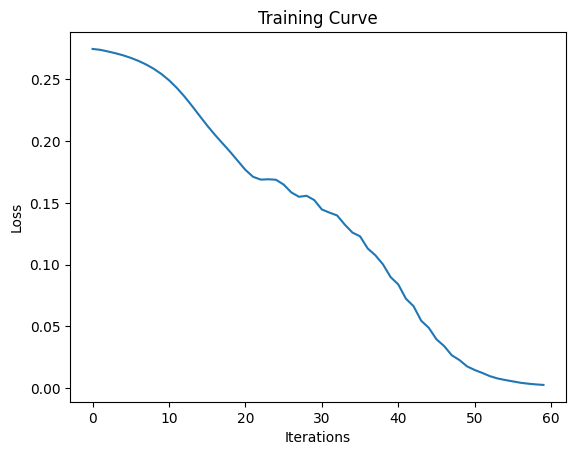

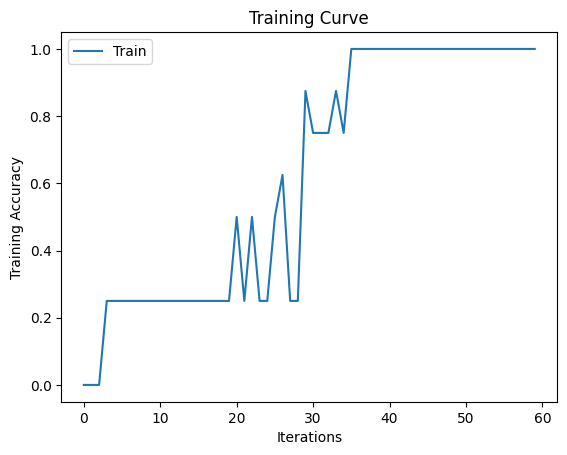

Final Training Accuracy: 1.0


In [ ]:
small_path = "/content/gdrive/MyDrive/Colab Notebooks/small_data"
small_count = torchvision.datasets.ImageFolder(small_path, transform=transform)

use_cuda = True

model = CNN_MNISTClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

#proper model
onlytrain(model, small_count, batch_size = 8, num_epochs=60)

### 3. Hyperparameter Search [10 pt]

### Part (a) - 1 pt

List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to
the model architecture.

Batch size, learning rate, epoch number

### Part (b) - 5 pt

Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

CUDA is available!  Training on GPU ...
epoch number  1 accuracy:  0.11029825548677546
epoch number  2 accuracy:  0.11029825548677546
epoch number  3 accuracy:  0.11029825548677546
epoch number  4 accuracy:  0.15644344400675295
epoch number  5 accuracy:  0.19977490151941474
epoch number  6 accuracy:  0.20483961733258302
epoch number  7 accuracy:  0.20821609454136183
epoch number  8 accuracy:  0.3196398424310636
epoch number  9 accuracy:  0.4395047833427124
epoch number  10 accuracy:  0.48171074845244793
epoch number  11 accuracy:  0.5407990996060776
epoch number  12 accuracy:  0.509848058525605
epoch number  13 accuracy:  0.5633089476646033
epoch number  14 accuracy:  0.5959482273494654
epoch number  15 accuracy:  0.6195835678109173
epoch number  16 accuracy:  0.5526167698368036
epoch number  17 accuracy:  0.6229600450196962
epoch number  18 accuracy:  0.666854248733821
epoch number  19 accuracy:  0.6657287563308948
epoch number  20 accuracy:  0.6994935284186832
epoch number  21 accura

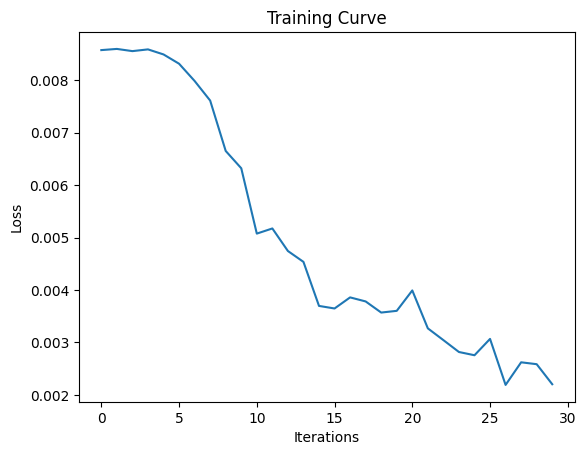

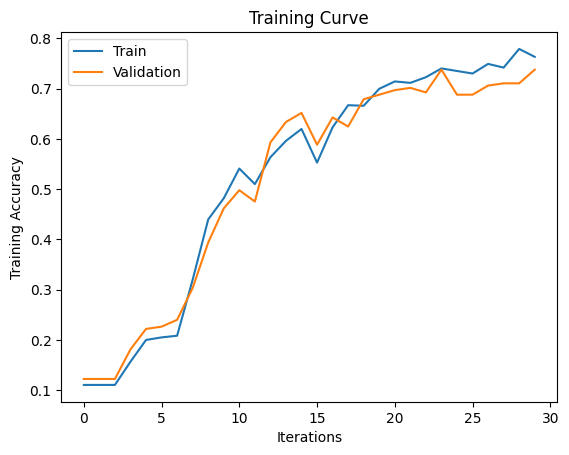

Final Training Accuracy: 0.7630838491840181
Final Validation Accuracy: 0.7375565610859729


In [ ]:
use_cuda = True

model = CNN_MNISTClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

#proper model
train(model, train_count, val_count, batch_size = 256, num_epochs=30)

CUDA is available!  Training on GPU ...
epoch number  1 accuracy:  0.14181204276871132
epoch number  2 accuracy:  0.19020821609454136
epoch number  3 accuracy:  0.40630275745638716
epoch number  4 accuracy:  0.4209341586944288
epoch number  5 accuracy:  0.48958919527293193
epoch number  6 accuracy:  0.5441755768148565
epoch number  7 accuracy:  0.5925717501406865
epoch number  8 accuracy:  0.6336522228474958
epoch number  9 accuracy:  0.642656162070906
epoch number  10 accuracy:  0.6212718064153067
epoch number  11 accuracy:  0.6764209341586944
epoch number  12 accuracy:  0.6409679234665167
epoch number  13 accuracy:  0.6831738885762522
epoch number  14 accuracy:  0.6938660664040518
epoch number  15 accuracy:  0.6944288126055149
epoch number  16 accuracy:  0.6471581316826112
epoch number  17 accuracy:  0.691052335396736
epoch number  18 accuracy:  0.7084974676420934
epoch number  19 accuracy:  0.7371975239167136
epoch number  20 accuracy:  0.7090602138435566
epoch number  21 accuracy: 

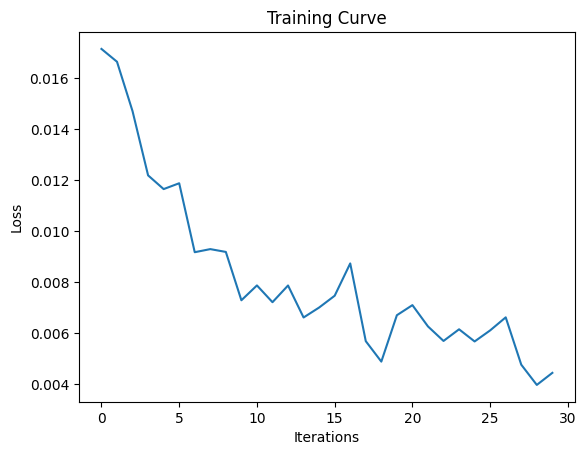

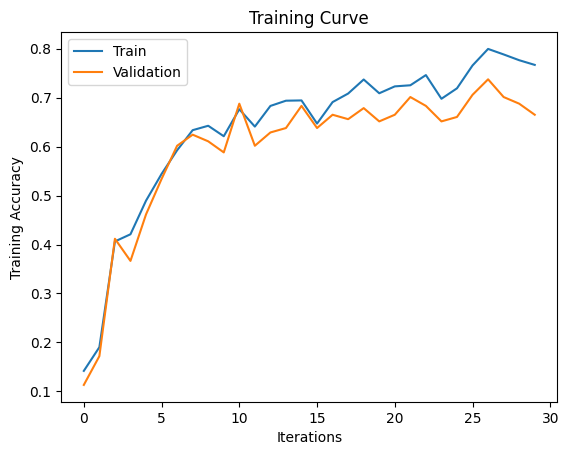

Final Training Accuracy: 0.76702307259426
Final Validation Accuracy: 0.665158371040724


In [ ]:
use_cuda = True

model = CNN_MNISTClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

#proper model
train(model, train_count, val_count, batch_size = 128, num_epochs=30)

CUDA is available!  Training on GPU ...
epoch number  1 accuracy:  0.11480022509848059
epoch number  2 accuracy:  0.12155317951603826
epoch number  3 accuracy:  0.16432189082723692
epoch number  4 accuracy:  0.11592571750140687
epoch number  5 accuracy:  0.19808666291502533
epoch number  6 accuracy:  0.1654473832301632
epoch number  7 accuracy:  0.1344963421496905
epoch number  8 accuracy:  0.1288688801350591
epoch number  9 accuracy:  0.13224535734383794
epoch number  10 accuracy:  0.2284749577940349
epoch number  11 accuracy:  0.21384355655599324
epoch number  12 accuracy:  0.21722003376477209
epoch number  13 accuracy:  0.2622397298818233
epoch number  14 accuracy:  0.32189082723691614
epoch number  15 accuracy:  0.36015756893640966
epoch number  16 accuracy:  0.3275182892515476
epoch number  17 accuracy:  0.5014068655036579
epoch number  18 accuracy:  0.4254361283061339
epoch number  19 accuracy:  0.5531795160382668
epoch number  20 accuracy:  0.5514912774338773
epoch number  21 ac

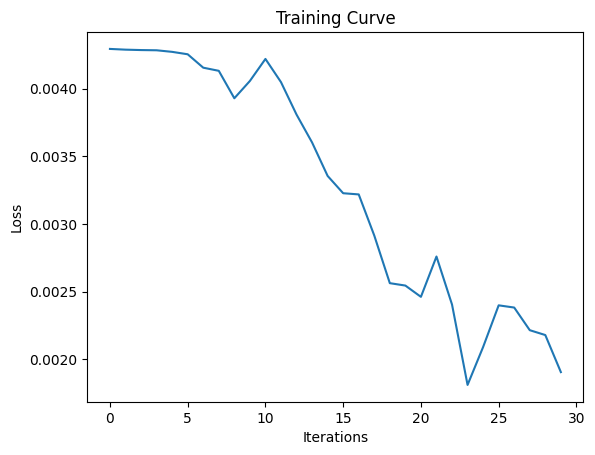

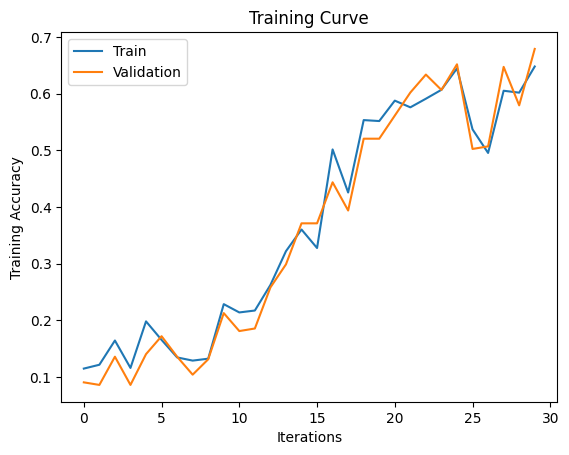

Final Training Accuracy: 0.6477208778840743
Final Validation Accuracy: 0.6787330316742082


In [ ]:
use_cuda = True

model = CNN_MNISTClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

#proper model
train(model, train_count, val_count, batch_size = 512, num_epochs=30)

CUDA is available!  Training on GPU ...
epoch number  1 accuracy:  0.11311198649409117
epoch number  2 accuracy:  0.1851435002813731
epoch number  3 accuracy:  0.2104670793472144
epoch number  4 accuracy:  0.20821609454136183
epoch number  5 accuracy:  0.18908272369161508
epoch number  6 accuracy:  0.3517163759144626
epoch number  7 accuracy:  0.29431626336522226
epoch number  8 accuracy:  0.4350028137310073
epoch number  9 accuracy:  0.501969611705121
epoch number  10 accuracy:  0.5627462014631401
epoch number  11 accuracy:  0.6375914462577378
epoch number  12 accuracy:  0.6539110861001688
epoch number  13 accuracy:  0.6764209341586944
epoch number  14 accuracy:  0.6775464265616207
epoch number  15 accuracy:  0.6623522791221159
epoch number  16 accuracy:  0.7242543612830613
epoch number  17 accuracy:  0.7281935846933033
epoch number  18 accuracy:  0.7422622397298818
epoch number  19 accuracy:  0.7658975801913337
epoch number  20 accuracy:  0.7844682048396173
epoch number  21 accuracy:

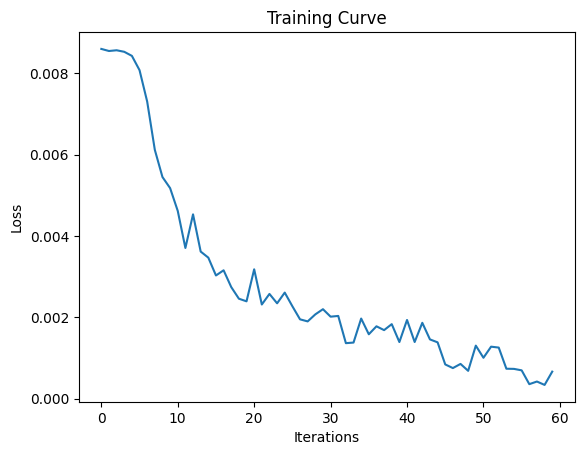

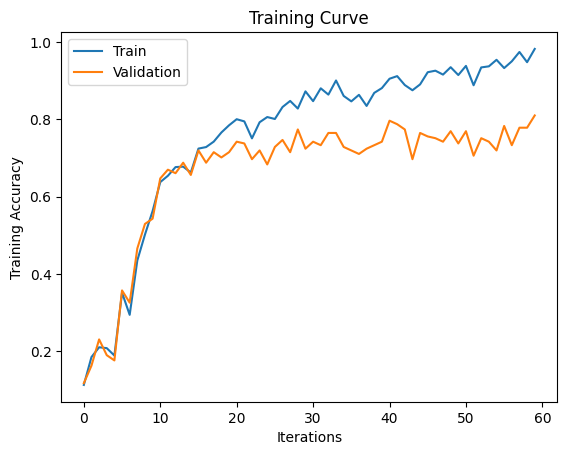

Final Training Accuracy: 0.9819921215531795
Final Validation Accuracy: 0.8099547511312217


In [ ]:
use_cuda = True

model = CNN_MNISTClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

#proper model
train(model, train_count, val_count, batch_size = 256, num_epochs=60)

### Part (c) - 2 pt
Choose the best model out of all the ones that you have trained. Justify your choice.

An batch size of 256 performed the best result out of all other batch sizes. So I choose the batch size of 256, apart from that I added the number of epoch, thus training for longer period of time. The final traning accuracy is 0.98 and validation accuracy is 0.8099.

In [ ]:
def train_save(model, data, val, batch_size=64, num_epochs=1, learning_rate=0.01):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):


            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################


            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
        iters.append(n)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader, val_loader, train=True)) # compute training accuracy
        val_acc.append(get_accuracy(model,train_loader, val_loader, train=False))  # compute validation accuracy
        n += 1
        print("epoch number ", epoch+1, "accuracy: ",train_acc[-1])
        model_path = get_model_name(model.name, batch_size, learning_rate, num_epochs)
        torch.save(model.state_dict(), model_path)

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))


CUDA is available!  Training on GPU ...
epoch number  1 accuracy:  0.14068655036578503
epoch number  2 accuracy:  0.11254924029262803
epoch number  3 accuracy:  0.15588069780528982
epoch number  4 accuracy:  0.23353967360720315
epoch number  5 accuracy:  0.2504220596510974
epoch number  6 accuracy:  0.17726505346088914
epoch number  7 accuracy:  0.19471018570624649
epoch number  8 accuracy:  0.20652785593697243
epoch number  9 accuracy:  0.22228474957794034
epoch number  10 accuracy:  0.22341024198086662
epoch number  11 accuracy:  0.2312886888013506
epoch number  12 accuracy:  0.28531232414181207
epoch number  13 accuracy:  0.2763083849184018
epoch number  14 accuracy:  0.32245357343837927
epoch number  15 accuracy:  0.28531232414181207
epoch number  16 accuracy:  0.3033202025886325
epoch number  17 accuracy:  0.3280810354530107
epoch number  18 accuracy:  0.32470455824423183
epoch number  19 accuracy:  0.3579065841305571
epoch number  20 accuracy:  0.45469893078221724
epoch number  2

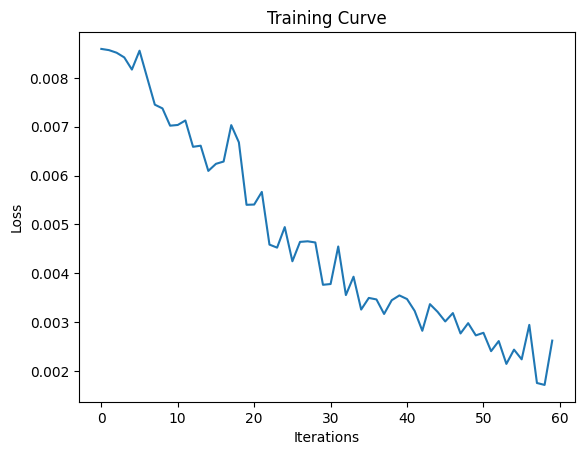

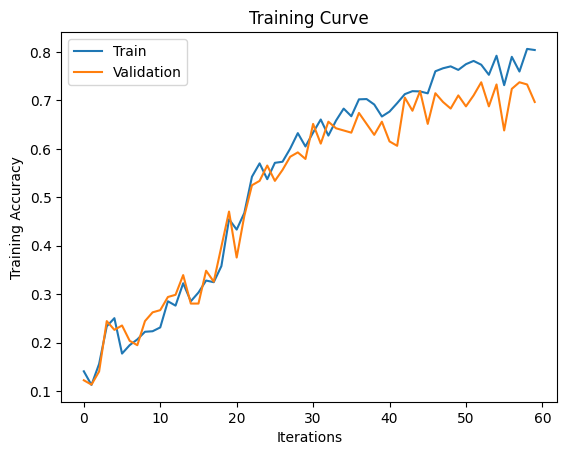

Final Training Accuracy: 0.8041643218908272
Final Validation Accuracy: 0.6968325791855203


In [ ]:

use_cuda = True

model = CNN_MNISTClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

#proper model
train_save(model, train_count, val_count, batch_size = 256, num_epochs=60)

### Part (d) - 2 pt
Report the test accuracy of your best model. You should only do this step once and prior to this step you should have only used the training and validation data.

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [ ]:
net = CNN_MNISTClassifier()
model_path = get_model_name(net.name, batch_size=256, learning_rate=0.01, epoch=60)
state = torch.load(model_path)
net.load_state_dict(state)
net = net.cuda()
test_loader = torch.utils.data.DataLoader(test_count, batch_size=256, shuffle = True)
accuracy = get_accuracy(net,test_loader, test_loader)
print("test accuracy = ", accuracy)

test accuracy =  0.7058823529411765


### 4. Transfer Learning [15 pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.

### Part (a) - 5 pt
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 208MB/s]


The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Compute the AlexNet features for each of your training, validation, and test data. Here is an example code
snippet showing how you can compute the AlexNet features for some images (your actual code might be
different):

**Save the computed features**. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

In [ ]:
import time
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

In [ ]:
path = "/content/gdrive/MyDrive/Colab Notebooks/Lab3_Gestures_Summer"
# classes are folders in each directory with these names
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']


In [ ]:
# resize all images to 224 x 224
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor()])

train_count = torchvision.datasets.ImageFolder(root, transform=transform, is_valid_file=isvalidtrain)
val_count = torchvision.datasets.ImageFolder(root, transform=transform, is_valid_file=isvalidvalid)
test_count = torchvision.datasets.ImageFolder(root, transform=transform, is_valid_file=isvalidtest)




In [ ]:
batch_size  = 1
num_workers = 1
# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_count, batch_size=batch_size,num_workers=num_workers,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(val_count, batch_size=batch_size, num_workers=num_workers,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(test_count,batch_size=batch_size,num_workers=num_workers,
                                          shuffle=True)



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim #for gradient descent
import numpy as np
from torch.utils.data import DataLoader, TensorDataset



# alexnet
import torchvision.models

def features_to_list(loader):
    features = []
    labels = []
    for img, label in iter(loader):
      tensor = torch.from_numpy(alexnet.features(img).detach().numpy())
      features.append(tensor)
      labels.append(label)
    dataset = TensorDataset(torch.stack(features), torch.tensor(labels))
    return dataset

In [ ]:
train_transfer = features_to_list(train_loader)
val_transfer = features_to_list(val_loader)
test_transfer = features_to_list(test_loader)


### Part (b) - 3 pt
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?

Here is an example of how your model may be called:

In [ ]:
#Artifical Neural Network Architecture
class ANNClassifier(nn.Module):
    def __init__(self):
        self.name = "ANN"
        super(ANNClassifier, self).__init__()
        self.fc1 = nn.Linear(256 * 6 * 6, 50)
        self.fc2 = nn.Linear(50, 9)

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

I choose an ANN with two layers because the feature is already extracted using the pretrained alexnet, meaning only classification is needed to be done. Thus I believe that fully connected layer would be the best choice for this role. Choosing two layer would be enough for the classification and is minimum in computing power. In this case, the output from feature extracting is Nx256x6x6, thus the input would need to be flattened and would thus be 256 * 6 * 6, and the output would be 9, corresponding to the 9 different classes. I choose to use relu as the activation function because it is a effective and simple choice to use.

### Part (c) - 5 pt
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.

CUDA is available!  Training on GPU ...
epoch number  1 accuracy:  0.678671918964547
epoch number  2 accuracy:  0.8497467642093416
epoch number  3 accuracy:  0.859313449634215
epoch number  4 accuracy:  0.9161508159819921
epoch number  5 accuracy:  0.9268429938097917
epoch number  6 accuracy:  0.9431626336522229
epoch number  7 accuracy:  0.9482273494653911
epoch number  8 accuracy:  0.9701744513224536
epoch number  9 accuracy:  0.9645469893078221
epoch number  10 accuracy:  0.9594822734946539
epoch number  11 accuracy:  0.9864940911648846
epoch number  12 accuracy:  0.9893078221722004
epoch number  13 accuracy:  0.9876195835678109
epoch number  14 accuracy:  0.9887450759707372
epoch number  15 accuracy:  0.9932470455824424
epoch number  16 accuracy:  0.9966235227912211
epoch number  17 accuracy:  0.9966235227912211
epoch number  18 accuracy:  0.9977490151941475
epoch number  19 accuracy:  0.9983117613956106
epoch number  20 accuracy:  0.9983117613956106
epoch number  21 accuracy:  0.9

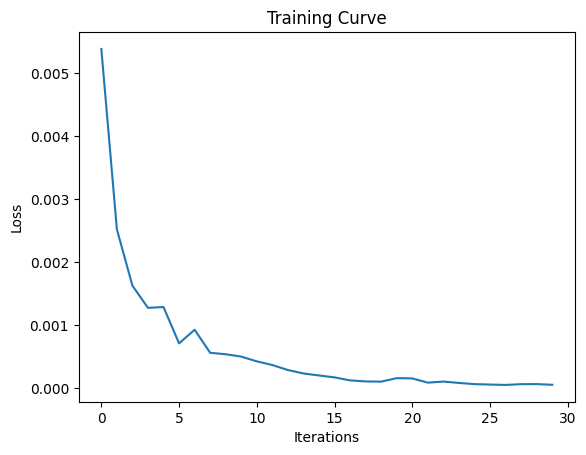

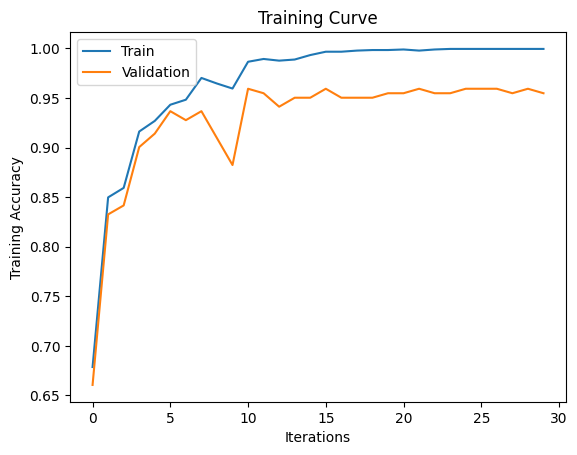

Final Training Accuracy: 0.9994372537985369
Final Validation Accuracy: 0.9547511312217195


In [ ]:
use_cuda = True

model = ANNClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

batch_size = 256
num_epoch = 30
#proper model
train_save(model,train_transfer,val_transfer, batch_size=batch_size, num_epochs=num_epoch)



### Part (d) - 2 pt
Report the test accuracy of your best model. How does the test accuracy compare to Part 3(d) without transfer learning?

In [ ]:
net = ANNClassifier()
model_path = get_model_name(net.name, batch_size=256, learning_rate=0.01, epoch=30)
state = torch.load(model_path)
net.load_state_dict(state)
net = net.cuda()
test_loader = torch.utils.data.DataLoader(test_transfer, batch_size=256, shuffle = True)
accuracy = get_accuracy(net,test_loader, test_loader)
print("test accuracy = ", accuracy)

test accuracy =  0.9502262443438914


The test accuracy is much higher than part 3(d) without transfer learning. the previous test accuracy is 0.70

### 5. Additional Testing [5 pt]
As a final step in testing we will be revisiting the sample images that you had collected and submitted at the start of this lab. These sample images should be untouched and will be used to demonstrate how well your model works at identifying your hand guestures.

Using the best transfer learning model developed in Part 4. Report the test accuracy on your sample images and how it compares to the test accuracy obtained in Part 4(d)? How well did your model do for the different hand guestures? Provide an explanation for why you think your model performed the way it did?

In [ ]:
small_path = "/content/gdrive/MyDrive/Colab Notebooks/small_data"
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor()])

small_count = torchvision.datasets.ImageFolder(small_path, transform=transform)
small_loader = torch.utils.data.DataLoader(small_count, batch_size=1,num_workers=1,
                                           shuffle=True)
small_transfer = features_to_list(small_loader)

net = ANNClassifier()
model_path = get_model_name(net.name, batch_size=256, learning_rate=0.01, epoch=30)
state = torch.load(model_path)
net.load_state_dict(state)
net = net.cuda()
test_loader = torch.utils.data.DataLoader(small_transfer, batch_size=256, shuffle = True)
accuracy = get_accuracy(net,test_loader, test_loader)
print("small batch accuracy = ", accuracy)


small batch accuracy =  1.0


The test accuracy is higher for small batch of data comparing to part 4(d) because small size of dataset is being used and it can be trained for more times becuase of its small size and thus achieving perfect accuracy.